# Aliasing
### The reason that strange artifacts appear in signals.

TypeError: object of type <class 'float'> cannot be safely interpreted as an integer.

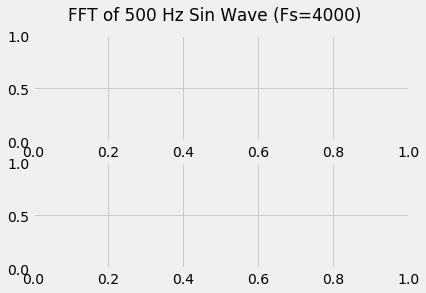

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

# style the plots so they're not so generic
plt.style.use('fivethirtyeight')

# plot fft of sampled signal
def fftPlot(axis, xf, yf, fs):
    axis.plot(xf, yf)
    axis.set(xlabel='Frequency (Hz)', ylabel='Real')

# plot original sin wave with samples shown
def aliasPlot(axis, x, y, fs, f_sin):
    # display first three periods of original signal
    fs_ideal = 10000
    n_display = fs_ideal / f_sin * 3
    x_ideal = np.linspace(0, 1.0 * n_display / fs_ideal, n_display - 1)
    y_ideal = np.sin(f_sin * 2 * np.pi * x_ideal)
    axis.plot(x_ideal, y_ideal)

    # display samples taken from three periods of signal 
    n_display = 3 * fs / f_sin
    axis.plot(x[:n_display + 1], y[:n_display + 1], 'ro')
    axis.set(xlabel='Time (sec)', ylabel='Amplitude')

# sample a given sin wave and create its FFT
def getSamplesAndFFT(N, fs, f_sin):
    # create wave from parameters
    x = np.linspace(0, N / fs, N - 1)
    y = np.sin(f_sin * 2 * np.pi * x)

    # fft of sampled sin wave
    xf = np.linspace(- fs / 2, fs / 2, N - 1, endpoint=False)
    yf = abs(scipy.fftpack.fft(y))
    yf = [w / fs for w in yf]   # account for sampling scaling
    yf = scipy.fftpack.fftshift(yf)
    return [x, y, xf, yf]

# sampling 500 hz sin wave at 4000 hz
N = 8000 
f_sin = 500
fs1 = 4000
[x, y, xf, yf] = getSamplesAndFFT(N, fs1, f_sin)

# sampling 500 hz sin wave at 800 hz
fs2 = 800
[x1, y1, xf1, yf1] = getSamplesAndFFT(N, fs2, f_sin)

# plot oversampled sin wave and fft results
fig, axs = plt.subplots(2, 1)
fig.suptitle('FFT of ' + str(f_sin) + ' Hz Sin Wave (Fs=' + str(fs1) + ')')
aliasPlot(axs[0], x, y, fs1, f_sin)
fftPlot(axs[1], xf, yf, fs1)

# plot undersampled sin wave and fft results
fig2, axs2 = plt.subplots(2, 1)
fig2.suptitle('FFT of ' + str(f_sin) + ' Hz Sin Wave (Fs=' + str(fs2) + ')')
aliasPlot(axs2[0], x1, y1, fs2, f_sin)
fftPlot(axs2[1], xf1, yf1, fs2)
plt.show()